# Recommendation System

Von  Jannis Breitenstein, Jonas Meyer, Verena Aschoff, Lucas Grewe, Thomas Wilmes <br>


Diese Notebook ist in folgende Abschnitte unterteilt:

+ [1. Import Bibliotheken](#1)<br>
+ [2. Laden und Aufbereiten der Filmdaten](#2)<br>
+ [3. Explorative Datenanalyse Load Movie-Data](#3)<br>
+ [3.1 Allgeime Daten über das Datenset](#3.1)<br>
+ [3.2 Wann wurden die Filme veröffentlicht?](#3.2)<br>
+ [3.3 Wie sind die Filme bewertet worden?](#3.3)<br>
+ [3.4 Wie sind die Filme bewertet worden?](#3.4)<br>
+ [3.5 Wie sind die Bewertungen für alle Filme und Benutzer verteilt](#3.5)<br>
+ [4. Filtern der Daten](#4)<br>
+ [5. Anweden des KNN-Modells](#5)<br>
+ [5.1 Ausgabe von Empfehlungen](#5.1)<br>

***

## <a id=1>1. Import Bibliotheken </a>

In [ ]:
#Während 

import sys

!{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install surprise
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install scikit-surprise 

# Wird benötigt, wenn man dieses Notebook über Colabs benutzen möchte
!{sys.executable} -m pip install google.colab
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install fastparquet
!{sys.executable} -m pip install seaborn

!{sys.executable} -m pip install fuzzywuzzy

In [92]:
# Zum Speichern der Daten
import pandas as pd

# Wird zur Erstellung mehrdimensionalen Arrays benötigt
import numpy as np

# interaktive Diagramme erstellen
import matplotlib.pyplot as plt
import seaborn as sns

# interaktive Diagramme erstellen
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Zum Verschieben von Listen
from collections import deque

# Ähnlichkeiten zwischen Vektoren zu berechnen
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# TO Fuzz
from fuzzywuzzy import fuzz


# Empfehlungssysteme nutzen
#import surprise as sp
#from surprise.model_selection import cross_validate

# To create deep learning models
#from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
#from keras.models import Model

# Zum erstellen von Matrizen
#from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix



***
## <a id=2>2. Laden und Aufbereiten der Filmdaten </a>

***

In [ ]:
#Definieren der Dateipfade

# Enhält alle Filme mit Namen, Jahr und Film-ID
movie_tile_File = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/movie_titles.csv'

#movie_tile_File_new = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Netflix_Daten/movie_titles_new.csv'
combined_data_1 = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/combined_data_1.txt'
combined_data_2 = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/combined_data_2.txt'
combined_data_3 = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/combined_data_3.txt'
combined_data_4 = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/combined_data_4.txt'

#Auslesen der Daten aus den CSV-Dateien

combined_data_1_raw = pd.read_csv(combined_data_1, header=None, names=['Cust_Id', 'Rating', 'Date'], usecols=[0, 1, 2])
combined_data_2_raw = pd.read_csv(combined_data_2, header=None, names=['Cust_Id', 'Rating', 'Date'], usecols=[0, 1, 2])
combined_data_3_raw = pd.read_csv(combined_data_3, header=None, names=['Cust_Id', 'Rating', 'Date'], usecols=[0, 1, 2])
combined_data_4_raw = pd.read_csv(combined_data_4, header=None, names=['Cust_Id', 'Rating', 'Date'], usecols=[0, 1, 2])

## Aufgrunddessen, dass die Combined Data nicht nicht einfach verarbeitet können, müssen die Daten erst ausgelesen und als neue Datei gespeichert werden,
#  um in Zukunft einfacher auf die Daten zugreifen zu können.

# Suche nach leeren Zeilen, um das Dataframe für jeden Film aufzuschneiden
tmp_movies = combined_data_1_raw[combined_data_1_raw['Rating'].isna()]['Cust_Id'].reset_index()  
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Verschiebe die movie_indices um eins, um Start- und Endpunkte aller Filme zu erhalten
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


# Sammeln aller Dataframes
user_data = []

# Iterieren über alle Filme
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Prüfen, ob es der letzte Film in der Datei ist
    if df_id_1<df_id_2:
        tmp_df = combined_data_1_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = combined_data_1_raw.loc[df_id_1+1:].copy()
        
    # Spalte Movie_id erstellen
    tmp_df['Movie_Id'] = movie_id
    
    # Datenrahmen an die Liste anhängen
    user_data.append(tmp_df)

# Alle Dataframes zusammenfassen
df_1 = pd.concat(user_data)
del user_data, combined_data_1_raw, combined_data_1, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id

### Dieses Vorgehen wird für die anderen Dataframes wiederholt.

tmp_movies = combined_data_2_raw[combined_data_2_raw['Rating'].isna()]['Cust_Id'].reset_index() 
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []


for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = combined_data_2_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = combined_data_2_raw.loc[df_id_1+1:].copy()
        
    tmp_df['Movie_Id'] = movie_id
    
    user_data.append(tmp_df)

df_2 = pd.concat(user_data)
del user_data, combined_data_2_raw, combined_data_2, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id


tmp_movies = combined_data_3_raw[combined_data_3_raw['Rating'].isna()]['Cust_Id'].reset_index() 
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []

for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = combined_data_3_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = combined_data_3_raw.loc[df_id_1+1:].copy()
        
    tmp_df['Movie_Id'] = movie_id
    
    user_data.append(tmp_df)


df_3 = pd.concat(user_data)
del user_data, combined_data_3_raw, combined_data_3, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id

tmp_movies = combined_data_4_raw[combined_data_4_raw['Rating'].isna()]['Cust_Id'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]


shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []

for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = combined_data_4_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = combined_data_4_raw.loc[df_id_1+1:].copy()
        
    tmp_df['Movie_Id'] = movie_id
    
    user_data.append(tmp_df)

df_4 = pd.concat(user_data)
del user_data, combined_data_4_raw, combined_data_4, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df_4.shape))

#Zusammenfügen der aller Daten in einer Variable
data = [df_1, df_2,df_3,df_4]
df_com = pd.concat(data)

# Löschen der Variablen
del df_1, df_2, df_3, df_4


In [ ]:
# Damit in Zukunft die Iteration nicht immer erneut Ausgeführt werden soll, werden die Daten in eine Parquet Datei geschrieben.
parquet_combined_data = 'C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/data_Comb.zip'

df_com.to_parquet(parquet_combined_data, index=False)
del parquet_combined_data

In [ ]:
#Einlesen der zuvor erstellen Parquet Datei.
parquet_combined_data = 'C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/data_Comb.zip'

df_com = pd.read_parquet(parquet_combined_data)
# Formatieren des Dateiformats
Convert_dic_data= {'Cust_Id': 'int64', 'Rating': 'float32','Date': 'str', 'Movie_Id': 'Int64'}
df= df_com.astype(Convert_dic_data)
del parquet_combined_data, Convert_dic_data

In [71]:
# Der nächste Schritt ist es, die Movie-Titel Datei zu importieren.
# Aufgrunddessen, dass Filme aus Seperatoren wie , oder ; enhalten, werden zunächst alle Daten in eine Spalte geladen und am Ende separiert. 
# Dateipfad

movie_tile_File = 'C:/Users/jsbreite/OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Netflix_Daten/movie_titles.csv'
df_movie_titles = pd.read_csv(movie_tile_File,
                           encoding = "ISO-8859-1",
                           delimiter= '\t',
                           header = None,
                           names = ['Ziel'])
                           # Speicher alle Daten erst in eine Reihe, danach trennt er diese
df_movie_titles[['Movie_Id', 'Year', 'Name']] = df_movie_titles['Ziel'].str.split(pat=",",n=2, expand=True)   

# Entfernen der Spalte Ziel
df_movie_titles= df_movie_titles.drop(['Ziel'], axis= 1)  

# Speichern des Dataframes in der entsprechenden Formatierung
Convert_dic= {'Movie_Id': 'int64','Year': 'object', 'Name': 'str'}
df_movie_titles = df_movie_titles.astype(Convert_dic)


del Convert_dic, movie_tile_File

In [37]:
# Damit in Zukunft das Einlesen und das Trennen der Spalten nicht immer erneut ausgeführt werden soll, werden die Daten in eine Parquet Datei geschrieben.
parquet_movietitles_data = 'C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/movie_titles_edit.zip'
df_movie_titles.to_parquet(parquet_movietitles_data, index=False)
del parquet_movietitles_data

In [72]:
#Einlesen der zuvor erstellen Parquet Datei.
parquet_movietitles_data = 'C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/movie_titles_edit.zip'

df_movie_titles = pd.read_parquet(parquet_movietitles_data)
# Formatieren des Dateiformats
Convert_dic= {'Movie_Id': 'int64', 'Year': 'object', 'Name': 'str'}
df_movie_titles= df_movie_titles.astype(Convert_dic)
del parquet_movietitles_data, Convert_dic


***
## <a id=3>3. Explorative Datenanalyse</a>

***

## 3.1. Allgeime Daten über das Dataset?</a>

In [ ]:
# Datenstruktur Filmbewertungen

display(df_com)

#Anzahl der Benutzer
num_users = len(df_com.Cust_Id.unique())

#Anzahl der eindeutigen FilmIds
num_items = len(df_com.Movie_Id.unique())
print('Es gibt {} eindeutige Users und {} eindeutige Filme im Dataframe'.format(num_users, num_items))

# Anzahl der Rating bei Gruppe
df_ratings_cnt_tmp = pd.DataFrame(df_com.groupby('Rating').size(), columns=['count'])
df_ratings_cnt_tmp

# Taringfrequenz
df_movies_cnt = pd.DataFrame(df_com.groupby('Movie_Id').size(), columns=['count'])
df_movies_cnt.head()
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


# Anzahl der von jedem Nutzer abgegebenen Bewertung
df_users_cnt = pd.DataFrame(df_com.groupby('Cust_Id').size(), columns=['count'])
df_users_cnt.head()
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

# Ausgabe der Datei Filmdaten

display(df_movie_titles)

del num_items, num_users, df_ratings_cnt_tmp, df_movies_cnt, df_users_cnt

## 3.2. Wann wurden die Filme veröffentlicht?</a>
***

In [73]:
# Daten einholen
data = df_movie_titles['Year'].value_counts().sort_index()

# Linie erstellen
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Layout erstellen
layout = dict(title = '{} Filme gruppiert nach Jahr der Veröffentlichung'.format(movie_titles.shape[0]),
              xaxis = dict(title = 'Erscheinungsjahr'),
              yaxis = dict(title = 'Filme'))

# Plot erstellen
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

del layout, trace, fig

***
## 3.3. Wie sind die Bewertungen verteilt?</a>
***

In [76]:
# Daten einholen
data = df_com['Rating'].value_counts().sort_index(ascending=False)

# Linie erstellen
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#db0000'))
#  Layout erstellen
layout = dict(title = 'Verteilung {} User-Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Plot erstellen
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Variablen löschen
del fig, layout, data, trace 

***
## 3.4. Wann sind die Filme bewertet worden?</a>
***

In [77]:
# Daten einholen
data = df_com['Date'].value_counts()
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movie-Ratings Grouped By Day'.format(df.shape[0]),
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Ratings'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Delete Variables
del fig, layout, data,  trace 

***
## 3.4. Wie ist die Verteilung von Filbewertungen und Benutzern?</a>
***

In [80]:
##### Ratings Per Movie #####
# Get data
data = df_com.groupby('Movie_Id')['Rating'].count().clip(upper=9999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 100),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie (Clipped at 9999)',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)



##### Ratings Per User #####
# Get data
data = df.groupby('Cust_Id')['Rating'].count().clip(upper=299)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 199)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Delete Variables
del fig, layout, data,  trace 

c:\Users\jsbreite\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



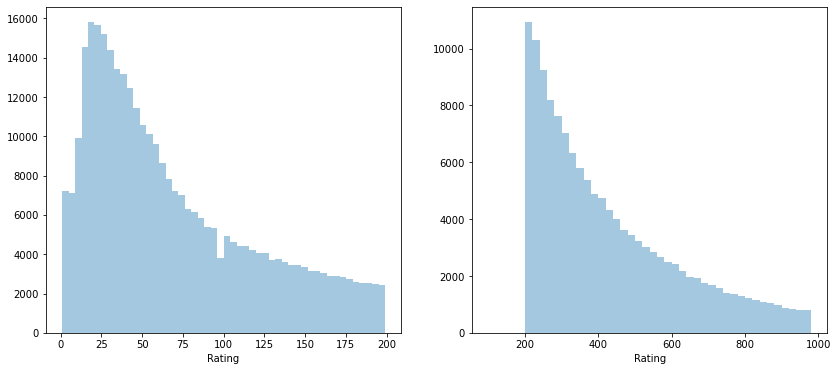

In [79]:
### Alternative Darstellung
## https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
#distribution of ratings users give¶
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Cust_Id')['Rating'].count()
sns.distplot(data[data  < 200], kde=False, ax=ax[0]);
sns.distplot(data[data  > 200], kde=False, ax=ax[1], bins=[i for i in range(100,1000,20)]);

del fig, ax, data

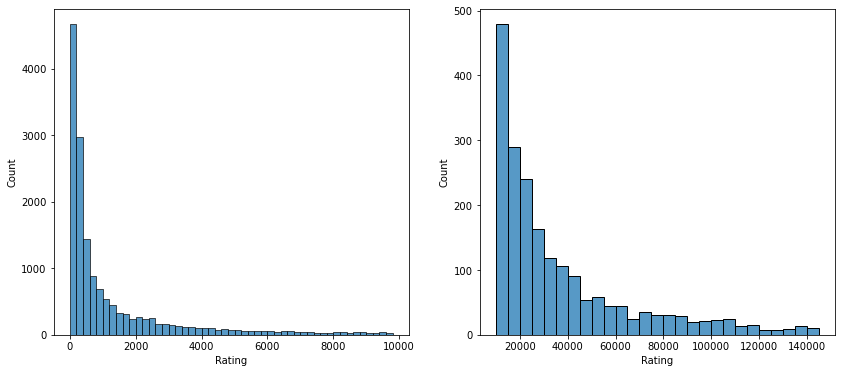

In [81]:
##Alternative Darstellung

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie_Id')['Rating'].count()


sns.histplot(data[data  < 10000], kde=False, ax=ax[0], bins=[i for i in range(0,10000,200)]);
sns.histplot(data[data  > 10000], kde=False, ax=ax[1], bins=[i for i in range(10000,150000,5000)]);


del fig, ax, data

***
## <a id=4>4. Filtern der Daten</a>
***

In [83]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df_com['Movie_Id'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df_com['Cust_Id'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df_com[(df_com['Movie_Id'].isin(filter_movies)) & (df_com['Cust_Id'].isin(filter_users))]

print('Shape User-Ratings ungefiltert:\t{}'.format(df.shape))
print('Shape User-Ratings gefiltert:\t{}'.format(df_filterd.shape))

# Löschen der Variablen
del filter_movies, filter_users, min_movie_ratings, min_user_ratings, df_com

***
## <a id=5>5. Anwenden des KNN-Modells</a>
***

In [87]:
# Entfernen der Spalte Datum aus 
df_filterd = df_filterd.drop('Date', axis= 1)

# Erstellen der Pivotmatrix movie-user, alle nicht vorhandenen Werte werden mit Null aufgeügllt
movie_user_mat = df_filterd.pivot(index='Movie_Id', columns='Cust_Id', values='Rating').fillna(0)

# Übergeben der Parameter für KNN
user_movie_table_matrix = csr_matrix(movie_user_mat.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto',n_jobs=-1)
model_knn.fit(user_movie_table_matrix)

# Erstellen eines Film-Recommendation Dataframe
df_recommendation = pd.DataFrame(columns=['Movie_Id', 'R_Movie_Id_1', 'R_Distance_1' , 'R_Movie_Id_2'  , 'R_Distance_2' , 'R_Movie_Id_3'  ,'R_Distance_3','R_Movie_Id_4' ,'R_Distance_4' ,'R_Movie_Id_5' ,'R_Distance_5'])
Convert_dic= {'Movie_Id': 'int32', 'R_Movie_Id_1': 'int32','R_Distance_1':'float','R_Movie_Id_2': 'int32','R_Distance_2':'float','R_Movie_Id_3': 'int32','R_Distance_3':'float','R_Movie_Id_4': 'int32','R_Distance_4':'float','R_Movie_Id_5': 'int32','R_Distance_5':'float' }
df_recommendation = df_recommendation.astype(Convert_dic)

# Erstellen einer Liste mit allen vorhandenen Movie_IDs in der Movie-User Matrix
movie_index_list = list(movie_user_mat.index.values)

# Löschen der Variablen
del Convert_dic

In [ ]:
### Durch das Iterieren der Daten werden 5 Empfehlungen für jeden Film erstellt und in ein Dataframe geschrieben.

for movie_id in movie_index_list:
    movie_id_mat = movie_user_mat.loc[[movie_id]].values.reshape(1,-1)
    distances, indices = model_knn.kneighbors(movie_id_mat, n_neighbors = 6)
    movie = []
    distance = []
    

    for i in range(0, len(distances.flatten())):
        if i != 0:
            movie.append(movie_user_mat.index[indices.flatten()[i]])
            distance.append(distances.flatten()[i])    

    m=pd.Series(movie,name='Movie_Id')
    d=pd.Series(distance,name='distance')
    recommend = pd.concat([m,d], axis=1)
    recommend = recommend.sort_values('distance',ascending=False)

    # Anfügen der Empfehlungen für jeden Film in 
    df_recommendation = df_recommendation.append({'Movie_Id': movie_id, 'R_Movie_Id_1': recommend['Movie_Id'].iloc[0], 'R_Distance_1':recommend['distance'].iloc[0],
        'R_Movie_Id_2': recommend['Movie_Id'].iloc[1], 'R_Distance_2':recommend['distance'].iloc[1],
        'R_Movie_Id_3': recommend['Movie_Id'].iloc[2], 'R_Distance_3':recommend['distance'].iloc[2],
        'R_Movie_Id_4': recommend['Movie_Id'].iloc[3], 'R_Distance_4':recommend['distance'].iloc[3],
        'R_Movie_Id_5': recommend['Movie_Id'].iloc[4], 'R_Distance_5':recommend['distance'].iloc[4]
        },ignore_index=True)
    

In [ ]:
# Dataframe Types bearbeiten
Convert_dic= {'Movie_Id': 'int32', 'R_Movie_Id_1': 'int32','R_Distance_1':'float','R_Movie_Id_2': 'int32','R_Distance_2':'float','R_Movie_Id_3': 'int32','R_Distance_3':'float','R_Movie_Id_4': 'int32','R_Distance_4':'float','R_Movie_Id_5': 'int32','R_Distance_5':'float' }
df_recommendation = df_recommendation.astype(Convert_dic)

# Runden der Berechnung von Distanz
df_rounded = df_recommendation.round({'R_Distance_1': 4, 'R_Distance_2':4,'R_Distance_3': 4, 'R_Distance_4':4,'R_Distance_5':4 })

# Ausgabe der Empfehlungen und IDs mit Rundungen als CSV
df_rounded.to_csv('C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/Movie_Recommendations_header_IDs_rounded.csv',index= False, sep=';',header='True', decimal=',')

# Mappen der Movie_IDs and die Datei Movie_Titles

df_rounded['Movie_Id'] = df_rounded['Movie_Id'].map(df_movie_titles.set_index('Movie_Id')['Name'])
df_rounded['R_Movie_Id_1'] = df_rounded['R_Movie_Id_1'].map(df_movie_titles.set_index('Movie_Id')['Name'])
df_rounded['R_Movie_Id_2'] = df_rounded['R_Movie_Id_2'].map(df_movie_titles.set_index('Movie_Id')['Name'])
df_rounded['R_Movie_Id_3'] = df_rounded['R_Movie_Id_3'].map(df_movie_titles.set_index('Movie_Id')['Name'])
df_rounded['R_Movie_Id_4'] = df_rounded['R_Movie_Id_4'].map(df_movie_titles.set_index('Movie_Id')['Name'])
df_rounded['R_Movie_Id_5'] = df_rounded['R_Movie_Id_5'].map(df_movie_titles.set_index('Movie_Id')['Name'])

# Ausgabe der Empfehlungen mit Filmnamen
df_rounded.to_csv('C:/Users/jsbreite\OneDrive - Jannis Breitenstein IT/Hochschule_Studium/5_Semester/Programmierprojekt/Daten/Movie_Recommendations_header_Titels_rounded.csv',index= False, sep=';',header='True', decimal=',')

#löschen der Variable

del df_rounded

***
##  5.1 Ausgabe Empfehlung </a>
***

In [89]:
# Erstellen einer Mappers von IDs zu Filmtitel
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movie_titles.set_index('Movie_Id').loc[movie_user_mat.index].Name))}

In [93]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    gibt die nächstliegende Übereinstimmung per Fuzzy zurück. Wenn keine Übereinstimmung gefunden wird, wird None zurückgegeben.
    
    Parameter
    ----------    
    mapper: dict, ordnet den Namen des Filmtitels dem Index des Films in den Daten zu

    fav_movie: str, Name des vom Benutzer eingegebenen Films
    
    verbose: bool, Protokoll ausgeben, wenn True

    Rückgabe
    ------
    Index der nächstgelegenen Übereinstimmung
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Kein Film gefunden')
        return
    if verbose:
        print('Folgende Filme wurden in der Datenbank gefunden: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('Deine Eingabe war:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Empfehlung für {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, mit Distanz auf {2}'.format(i+1, reverse_mapper[idx], dist))

In [95]:
my_favorite = 'Lord of the Rings: The Two Towers,'

make_recommendation(
    model_knn=model_knn,
    data=user_movie_table_matrix,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=5)

You have input movie: Lord of the Rings: The Two Towers,
Found possible matches in our database: ['Lord of the Rings: The Two Towers', 'Lord of the Rings: The Two Towers: Bonus Material', 'Lord of the Rings: The Two Towers: Extended Edition', 'Lord of the Rings: The Return of the King', 'Lord of the Rings: The Fellowship of the Ring', 'Lord of the Rings: The Fellowship of the Ring: Bonus Material', 'Planet of the Apes: The TV Series', 'The Lord of the Rings', 'Lord of the Rings: The Return of the King: Extended Edition']

Recommendation system start to make inference
......

Recommendations for Lord of the Rings: The Two Towers,:
1: Spider-Man, with distance of 0.23427198412529227
2: The Matrix, with distance of 0.20976050334280294
3: Pirates of the Caribbean: The Curse of the Black Pearl, with distance of 0.1862813204892686
4: Lord of the Rings: The Return of the King, with distance of 0.10349070769739421
5: Lord of the Rings: The Fellowship of the Ring, with distance of 0.08472268628